## Weather hazards

### Hazards we consider
### Air quality: Dust, Smoke, Fire
- ABI - L2 - ADPC - Advanced Baseline Imager Level 2 Aerosol Detection CONUS

- ABI - L2 - FDCC - Advanced Baseline Imager Level 2 Fire (Hot Spot Characterization) CONUS

### Lightning
- GLM - L2 - LCFA - Geostationary Lightning Mapper Level 2 Lightning Detection

## Peligros Meteorológicos

### Peligros que consideramos
### Calidad del aire: Polvo, Humo, Incendio
- ABI - L2 - ADPC - Generador de imágenes de referencia avanzado Nivel 2 Detección de aerosoles en los Estados Unidos

- ABI - L2 - FDCC - Generador de imágenes de referencia avanzado Nivel 2  Fuego(Caracterización de puntos calientes) en los Estados Unidos

### Relámpago
- GLM - L2 - LCFA - Mapeador de relámpago geoestacionario Nivel 2 Detección de relámpagos

In [ ]:
# Install and import libraries
# Instala y importa bibliotecas

!pip install cartopy
!pip install datetime
!pip install s3fs
!pip install xarray
!pip install matplotlib
!pip install numpy
!pip install ipywidgets
!pip install pandas

from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
import s3fs
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

### Define functions

### Define funciones

In [ ]:
# Open chosen file as xarray dataset
# Abre el archivo elegido como conjunto de datos xarray

def open_file_xarray(file):
    remote_file = fs.open(file, mode = 'rb')
    dataset = xr.open_dataset(remote_file, engine = 'h5netcdf')
    return dataset

In [ ]:
# Process ABI ADP smoke/dust detection (baseline algorithm)
# Procesa la detección de humo/polvo de ABI ADP (algoritmo de referencia)

def process_abi_adp_detection(ds):

    # Convert xarray Data Arrays to NumPy masked arrays with correct dtype
    # Convierta matrices de datos xarray en matrices enmascaradas NumPy con el tipo dtype correcto

    # Select "smoke present" (Smoke = 1) and "dust present" (Dust = 1) pixels
    # Seleccione píxeles con "humo presente" (Humo = 1) y "polvo presente" (Polvo = 1)

    smoke_detection = ds.Smoke.where(ds.Smoke == 1).to_masked_array().astype('uint8')
    dust_detection = ds.Dust.where(ds.Dust == 1).to_masked_array().astype('uint8')
    dqf = ds.DQF.to_masked_array().astype('uint16')

    # Process "Smoke" and "Dust" pixels using "DQF" variable flags
    # Procese píxeles de "humo" y "polvo" utilizando indicadores variables "DQF"

    # Select dust pixels outside of sun-glint areas using "DQF" bit 6
    # Seleccione píxeles de polvo fuera de las áreas de brillo solar usando el bit 6 "DQF"

    # Flag values: outside sun-glint = 0, within sun-glint = 64
    # Valores marcados: fuera del brillo del sol = 0, dentro del brillo del sol = 64

    dust_detection = np.ma.masked_where(dqf & 64 == 64, dust_detection)
    # Select smoke & dust pixels within valid SZA/VZA using "DQF" bit 7
    # Seleccione píxeles de humo y polvo dentro de SZA/VZA válido usando el bit 7 "DQF"

    # Flag values: within valid SZA/VZA = 0, outside of valid SZA/VZA = 128
    # Valores marcados: dentro de SZA/VZA válido = 0, fuera de SZA/VZA válido = 128

    smoke_detection = np.ma.masked_where(dqf & 128 == 128, smoke_detection)
    dust_detection = np.ma.masked_where(dqf & 128 == 128, dust_detection)

    return smoke_detection, dust_detection

In [ ]:
# Calculate latitude & longitude from GOES ABI fixed grid projection (using xarray)
# Calcule la latitud y la longitud a partir de la proyección de grilla fija de GOES ABI (usando xarray)
def calculate_abi_lat_lon(ds):

    # Read in GOES ABI fixed grid projection variables and constants
    # Leer las variables y constantes de proyección de grilla fija de GOES ABI
    x_coordinate_1d = ds.x  # E/W scanning angle in radians | Ángulo de exploración este/oeste en radianes
    y_coordinate_1d = ds.y  # N/S elevation angle in radians  | Ángulo de escaneo norte/sur en radianes
    projection_info = ds.goes_imager_projection  # ABI fixed grid contstants  | Constantes de proyección de grilla fija de GOES ABI
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    # Crear matrices de coordenadas 2D a partir de vectores de coordenadas 1D
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    # Ecuaciones para calcular latitud y longitud
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    lon = np.nan_to_num(lon, nan = -999.99)
    lat = np.nan_to_num(lat, nan = -999.99)

    return lat, lon

### Choose date and time to get data (default values are current date and time)

### Elija la fecha y la hora para obtener datos (los valores predeterminados son la fecha y hora actuales)

In [ ]:
# Create a date picker
# Crear un selector de fechas

date_picker = widgets.DatePicker(description = 'Pick a Date | Elija una fecha', value = datetime.utcnow())
display(date_picker)

# Create a hour slider for selection
# Crear un control deslizante de hora para la selección

hour_slider = widgets.IntSlider(value = datetime.utcnow().hour, min = 0, max = 23, step = 1, description = 'Hour | Hora', orientation = 'horizontal')
display(hour_slider)

DatePicker(value=datetime.datetime(2023, 10, 25, 19, 49, 55, 771482), description='Pick a Date | Elija una fec…

IntSlider(value=19, description='Hour | Hora', max=23)

In [ ]:
selected_date = date_picker.value
selected_hour = hour_slider.value

y, m, d, h = selected_date.year, selected_date.month, selected_date.day, selected_hour
print(f"Selected Date and Time: {y}-{m:02d}-{d:02d} {h:02d}:00 \n")
print(f"Fecha y hora seleccionadas: {y}-{m:02d}-{d:02d} {h:02d}:00")

year = str(selected_date.strftime('%Y'))
julian = str(selected_date.strftime('%j')).zfill(3)
hour = str(selected_hour).zfill(2)

Selected Date and Time: 2023-10-25 19:00 

Fecha y hora seleccionadas: 2023-10-25 19:00


### Download files from AWS and preprocess data

[Registry of Open Data on AWS](https://registry.opendata.aws/noaa-goes/)

### Descargar archivos de AWS y preprocesar datos

[Registro de Datos Disponibles en AWS](https://registry.opendata.aws/noaa-goes/)

In [ ]:
fs = s3fs.S3FileSystem(anon=True)

# Choose between GOES satellites: 16, 17 and 18
# Elige entre los satélites GOES: 16, 17 and 18
# noaa-goes17, noaa-goes18
bucket = 'noaa-goes16'

# Products
# Productos
products = {'adpc': 'ABI-L2-ADPC', 'fdcc': 'ABI-L2-FDCC', 'glm': 'GLM-L2-LCFA'}

# ADPC
adpc_data = bucket + '/' + products['adpc'] + '/'  + year + '/' + julian + '/' + hour
adpc_files = fs.ls(adpc_data)
print(adpc_files[-1])
adpc_ds = open_file_xarray(adpc_files[-1])

# Calculate latitude and longitude
# Calcula la latitud y la longitud
lat, lon = calculate_abi_lat_lon(adpc_ds)

# Process ADP smoke and dust detection
# Procesa la detección de humo y polvo del ADP
smoke_detection, dust_detection = process_abi_adp_detection(adpc_ds)

# FDCC
fdcc_data = bucket + '/' + products['fdcc'] + '/'  + year + '/' + julian + '/' + hour
fdcc_files = fs.ls(fdcc_data)
print(fdcc_files[-1])
fdcc_ds = open_file_xarray(fdcc_files[-1])
frp = fdcc_ds.Power

# GLM
glm_data = bucket + '/' + products['glm'] + '/'  + year + '/' + julian + '/' + hour
glm_files = fs.ls(glm_data)
print(glm_files[-1])
glm_ds = open_file_xarray(glm_files[-1])

# Create arrays of the flash lat and lons
# Crear matrices de latitud y longitud del relámpago
flash_lat = glm_ds.variables['flash_lat'][:]
flash_lon = glm_ds.variables['flash_lon'][:]

# Close the files
# Cerra los archivos
adpc_ds.close()
frp.close()
glm_ds.close()

noaa-goes16/ABI-L2-ADPC/2023/298/19/OR_ABI-L2-ADPC-M6_G16_s20232981941175_e20232981943548_c20232981944594.nc


<ipython-input-4-9c5a9bf76b95>:25: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


noaa-goes16/ABI-L2-FDCC/2023/298/19/OR_ABI-L2-FDCC-M6_G16_s20232981946175_e20232981948548_c20232981949224.nc
noaa-goes16/GLM-L2-LCFA/2023/298/19/OR_GLM-L2-LCFA_G16_s20232981949000_e20232981949200_c20232981949214.nc


### Figure of the weather hazards on CONUS

### Figura de los peligros climáticos en EE.UU

/usr/local/lib/python3.10/dist-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


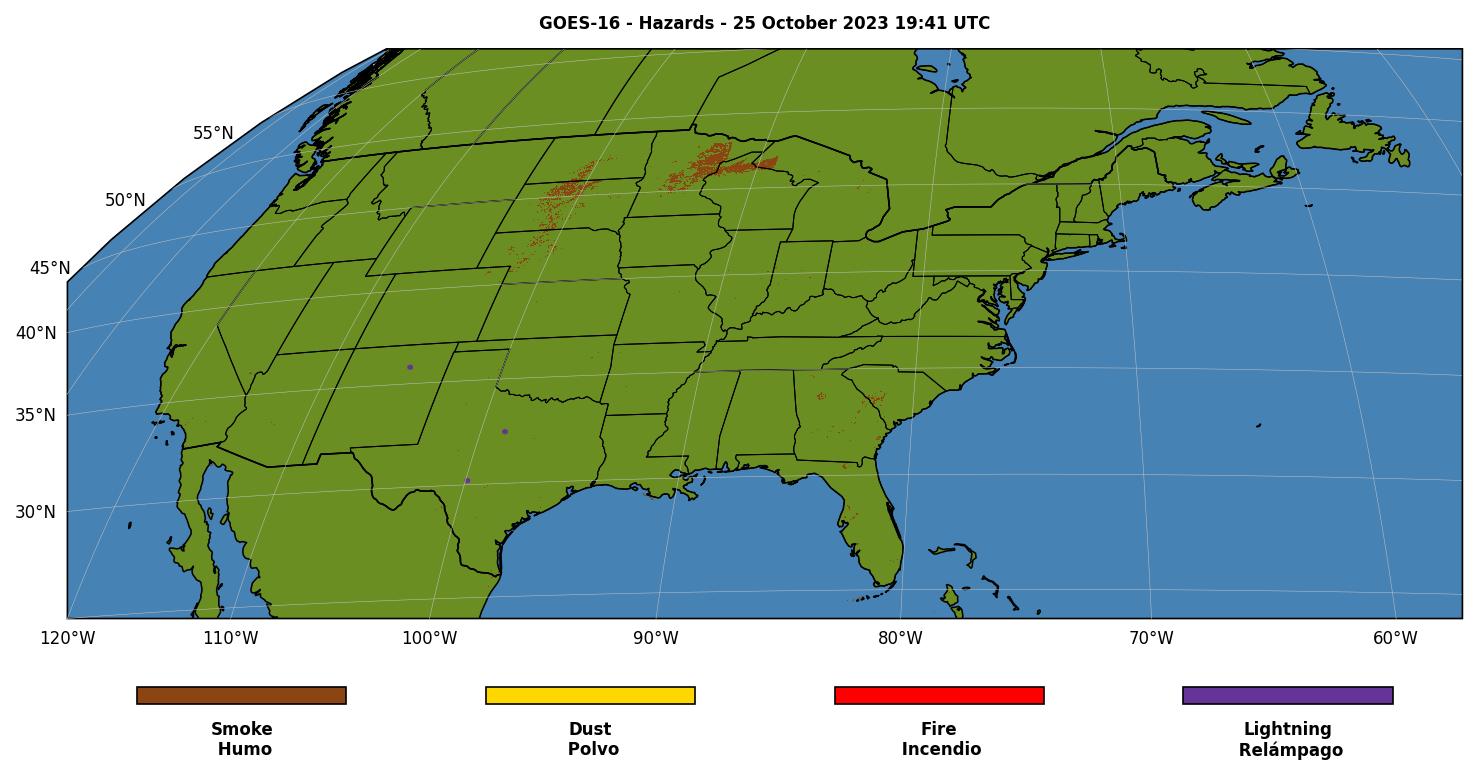

In [ ]:
# Set up figure in matplotlib
# Configura figura en matplotlib
fig = plt.figure(figsize=(12, 12), dpi = 150)

# Set up Projection
# Configura proyección
projection_variables = adpc_ds.goes_imager_projection
satellite_height = projection_variables.perspective_point_height
semi_major_axis = projection_variables.semi_major_axis
semi_minor_axis = projection_variables.semi_minor_axis
central_longitude = projection_variables.longitude_of_projection_origin
globe = ccrs.Globe(semimajor_axis = semi_major_axis, semiminor_axis = semi_minor_axis)
geo_projection = ccrs.Geostationary(central_longitude = central_longitude, satellite_height = satellite_height, globe = globe, sweep_axis = 'x')

# Set map projection using native geostationary map projection
# Configura la proyección del mapa utilizando la proyección del mapa geoestacionario nativo
ax = plt.axes(projection=geo_projection)

# Format lat/lon gridlines & labels using cartopy
# Configure las líneas de grilla y subtítulos de latitud/longitud usando cartopy
gl = ax.gridlines(draw_labels=True, linewidth=0.25, xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 5), color='silver', zorder=3)
gl.right_labels = None
gl.top_labels = None
gl.ypadding = 5
gl.xpadding = 5
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()

# Add coastlines & borders (1:50m medium resolution)
# Agrega costas y fronteras (resolución media 1:50 m)
ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_0_countries', scale = '50m'), linewidth = 0.75, facecolor = 'none', edgecolor = 'k', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces', scale = '50m'), linewidth = 0.5, facecolor = 'none', edgecolor = 'k', zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'ocean', scale = '50m'),facecolor = 'steelblue')
ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'land', scale = '50m'), facecolor = 'olivedrab')

# Defined area
# Área definida
box_array = [-120,-57,25,55]
ax.set_extent(box_array, ccrs.PlateCarree())

# Set colormaps for hazards
# Configura paleta de colores para los peligros.
cmap1 = mpl.colors.ListedColormap(['saddlebrown'])
cmap2 = mpl.colors.ListedColormap(['gold'])
cmap3 = mpl.colors.ListedColormap(['red'])
cmap4 = mpl.colors.ListedColormap(['rebeccapurple'])

# Plot smoke and dust detection, Fire Radiative Power, Lightning Flashes
# Plot detección de humo y polvo, potencia radiativa de fuego, relámpagos
plot1 = ax.pcolormesh(lon, lat, smoke_detection, cmap = cmap1, transform = ccrs.PlateCarree(), zorder = 2)
plot2 = ax.pcolormesh(lon, lat, dust_detection, cmap = cmap2, transform = ccrs.PlateCarree(), zorder = 2)
plot3 = ax.pcolormesh(lon, lat, frp, cmap = cmap3)
plot4 = ax.hexbin(flash_lon, flash_lat, gridsize = 500, bins='log',transform = ccrs.PlateCarree(), cmap = cmap4, vmin = 1, vmax = 30, zorder = 2)

# Add smoke detection colorbar
# Agregar paleta de colores de detección de humo
cb1_ax = ax.inset_axes([0.05, -0.15, 0.15, 0.03])
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap = cmap1, orientation = 'horizontal')
cb1.set_label(label = 'Smoke\n Humo', size = 8, weight = 'bold')
cb1.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb1.ax.tick_params(which = 'major', length = 0)

# Add dust detection colorbar
# Agregar paleta de colores de detección de polvo
cb2_ax = ax.inset_axes([0.3, -0.15, 0.15, 0.03])
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap = cmap2, orientation = 'horizontal')
cb2.set_label(label = 'Dust\n Polvo', size = 8, weight = 'bold')
cb2.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb2.ax.tick_params(which = 'major', length = 0)

# Add Fire Radiative Power colorbar
# Agregar paleta de colores de potencia radiativa de fuego
cb3_ax = ax.inset_axes([0.55, -0.15, 0.15, 0.03])
cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap = cmap3, orientation = 'horizontal')
cb3.set_label(label = 'Fire\n Incendio', size = 8, weight = 'bold')
cb3.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb3.ax.tick_params(which = 'major', length = 0)

# Add Lightning Flash colorbar
# Agregar paleta de colores de relámpagos
cb4_ax = ax.inset_axes([0.8, -0.15, 0.15, 0.03])
cb4 = mpl.colorbar.ColorbarBase(cb4_ax, cmap = cmap4, orientation = 'horizontal')
cb4.set_label(label = 'Lightning\n Relámpago', size = 8, weight = 'bold')
cb4.ax.xaxis.set_major_formatter(ticker.NullFormatter())
cb4.ax.tick_params(which = 'major', length = 0)

# Format title to plot
# Formata el título para el gráfico
file_name = adpc_files[-1].split('/')[-1]
julian = datetime.strptime(file_name.split('_')[3][1:8], '%Y%j').date()
observation_date = julian.strftime('%d %B %Y')
image_title = 'GOES-'+ file_name.split('_')[2][1:] + ' - Hazards - ' + observation_date + ' ' + file_name.split('_')[3][8:10] + ':' + file_name.split('_')[3][10:12] + ' UTC'
plt.title(image_title, pad = 10, size = 8, weight = 'bold')

plt.show()

# Close plot
# Cerra gráfico
plt.close()